# Times Series 2: Auto-Regressive Models

[Source](https://medium.com/auquan/time-series-analysis-ii-auto-regressive-models-d0cb1a8a7c43)

Now we introduce more sophisticated models, auto-regressive & moving average models

In [2]:
# Prepare packages
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

#code completion, click tab after starting
%config IPCompleter.greedy=True 

In [3]:
# Plotting function for use later:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## Formula for Auto-Regressive model with parameter p 
$\begin{aligned}
x_t = \alpha_1*x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p} t_i\alpha_ix_{t-i}+w_t
\end{aligned}$


# Simulate AR(1) process with a= 0



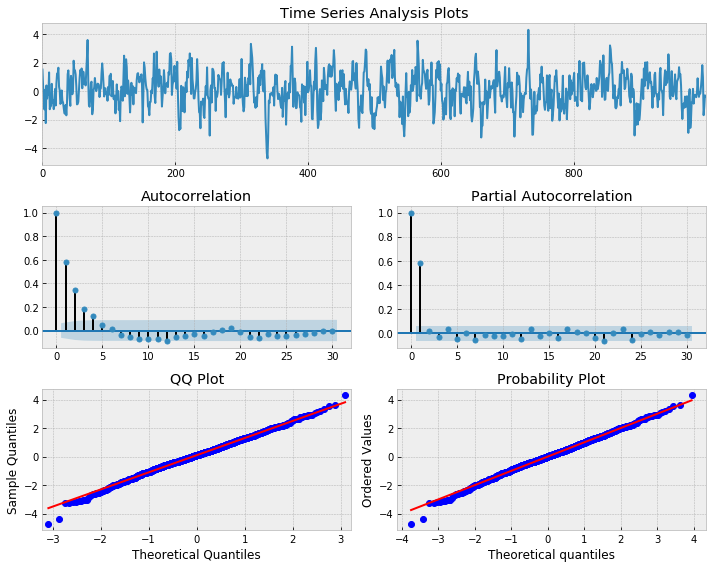

In [4]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1]+w[t]
    
_ = tsplot(x, lags=30) #don't need output

Because partial correlation drops off after 1, this correcting says that this is most likely a AR(1) model 

## Data Fitting

In [5]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = sm.tsa.AR(x).fit(maxlag=30,ic = 'aic', trend = 'nc')
est_order = sm.tsa.AR(x).select_order(maxlag=30,ic='aic',trend='nc')

true_order = 1

In [6]:
print('\nalpha estimate: %3.5f | order_estimate %s' % (mdl.params, est_order))
print('\ntrue alpha = %s | true order = %s' % (a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


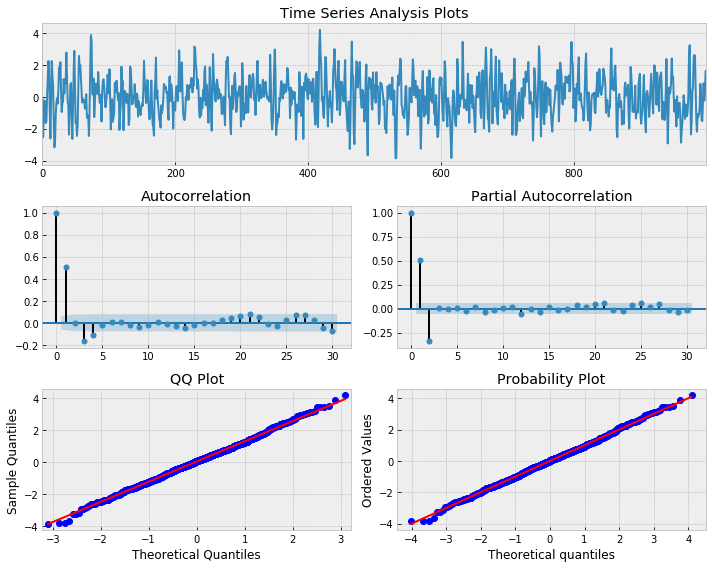

In [7]:
# Now try and fit AR(2) with a1 and a2 specified below

n = int(1000)
alphas = np.array([.666,-.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [8]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))


coef estimate: 0.6760 -0.3393 | order estimate 2


## Note on choosing number of lags

In [9]:
mdl = smt.AR(ar2).fit()
print ('Parameters')
print (mdl.params)
print ('Standard Error')
print (mdl.bse)

Parameters
[ 3.57345632e-02  6.67118523e-01 -3.40041205e-01  9.01909128e-03
 -1.11520048e-02  2.14435279e-02 -4.83381895e-02  3.28287551e-02
 -2.38531001e-02 -4.90031065e-04 -3.12735473e-02  5.21112625e-02
 -5.85303137e-02  2.17108859e-02 -5.58739239e-02  2.79663351e-02
 -6.45697812e-03 -2.90269682e-02  3.79624698e-02  1.12370300e-02
  2.54545125e-03  5.79634021e-02]
Standard Error
[0.03330767 0.03229192 0.03882052 0.04032568 0.04032737 0.04031148
 0.04030305 0.04029053 0.04027444 0.04025271 0.04022384 0.04018031
 0.0402171  0.04026555 0.04027908 0.04028844 0.04027529 0.04028007
 0.04028697 0.04034915 0.03870137 0.03212717]


In [11]:
#Use AIC to select best lag

N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = smt.AR(ar2)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print('Number of parameters in minimum AIC model %s' % (model_min+1))

Number of parameters in minimum AIC model 2


## Evaluating residuals

In [12]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _ , _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect residuals are not normally distributed')
else:
    print ('The residuals seem normally distributed')

The residuals seem normally distributed


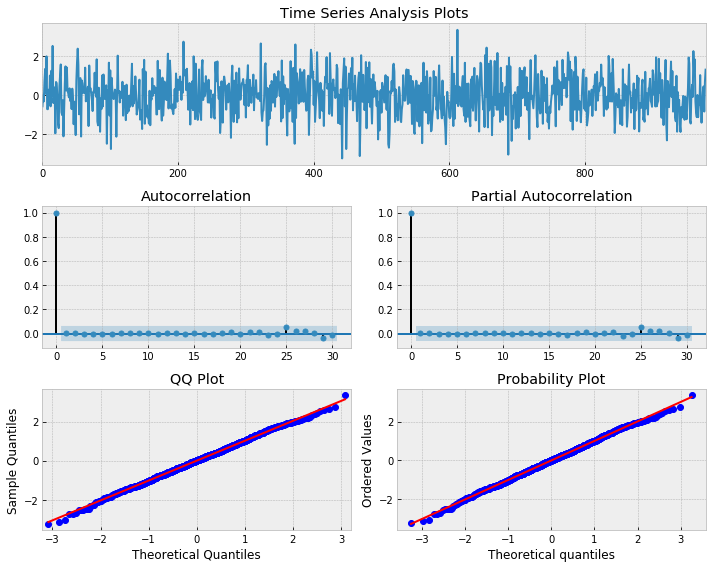

In [13]:
tsplot(mdl.resid, lags=30)

## Other data
stock market data probably not normal